# Macroeconomic Forecasting Model with Sentiment Scores

### Loading Package

In [1]:
import numpy as np
import pandas as pd

### Reading in Macroeconomics Data

In [2]:
data_US_unemployment = pd.read_csv(r"Data\FRED\UNRATE.csv").set_index('DATE')
data_US_unemployment.index = pd.to_datetime(data_US_unemployment.index)
data_US_unemployment['year'] = data_US_unemployment.index.year
data_US_unemployment['month'] = data_US_unemployment.index.month
data_US_unemployment = data_US_unemployment.reset_index().set_index(['year','month']).drop(columns = ['DATE'])

In [3]:
data_US_gdp = pd.read_csv(r"Data\FRED\GDPC1.csv").set_index('DATE')
data_US_gdp.index = pd.to_datetime(data_US_gdp.index)
data_US_gdp['year'] = data_US_gdp.index.year
data_US_gdp['quarter'] = np.ceil(data_US_gdp.index.month / 3).astype(int)
data_US_gdp = data_US_gdp.reset_index().set_index(['year','quarter']).drop(columns = ['DATE'])

In [4]:
data_US_inflation = pd.read_csv(r"Data\FRED\CPIAUCNS.csv").set_index('DATE')
data_US_inflation.index = pd.to_datetime(data_US_inflation.index)
data_US_inflation['year'] = data_US_inflation.index.year
data_US_inflation['month'] = data_US_inflation.index.month
data_US_inflation = data_US_inflation.reset_index().set_index(['year','month']).drop(columns = ['DATE'])

### Reading in Sentiment Score Data

In [5]:
sentiment_score_lr = pd.read_csv(r"Data\sentiment_score_lr.csv").set_index(['year','month']).drop(columns=['exception'])
sentiment_score_lr["sum"] = sentiment_score_lr.sum(axis=1)
sentiment_score_lr = sentiment_score_lr.div(sentiment_score_lr["sum"], axis=0).drop(columns=['sum'])

sentiment_score_lstm = pd.read_csv(r"Data\sentiment_score_lstm.csv").set_index(['year','month']).drop(columns=['exception'])
sentiment_score_lstm["sum"] = sentiment_score_lstm.sum(axis=1)
sentiment_score_lstm = sentiment_score_lstm.div(sentiment_score_lstm["sum"], axis=0).drop(columns=['sum'])

In [6]:
sentiment_score_lr = sentiment_score_lr.rename(columns={"positive": "positive_lr", "neutral": "neutral_lr", "negative": "negative_lr"})
sentiment_score_lstm = sentiment_score_lstm.rename(columns={"positive": "positive_lstm", "neutral": "neutral_lstm", "negative": "negative_lstm"})
sentiment_score_lr["sentiment_lr_diff"] = sentiment_score_lr["positive_lr"] - sentiment_score_lr["negative_lr"]
sentiment_score_lstm["sentiment_lstm_diff"] = sentiment_score_lstm["positive_lstm"] - sentiment_score_lstm["negative_lstm"]
sentiment_score_lr["sentiment_lr_ratio"] = sentiment_score_lr["positive_lr"] / sentiment_score_lr["negative_lr"]
sentiment_score_lstm["sentiment_lstm_ratio"] = np.log(sentiment_score_lstm["positive_lstm"] / sentiment_score_lstm["negative_lstm"])
sentiment_score = sentiment_score_lr.join(sentiment_score_lstm)

In [7]:
year1 = []
year4 = []
period4 = []
i = 2013
year1.append(i)
for j in range(1, 4):
    year4.append(i)
    period4.append(j+1)
for i in range(2014, 2021):
    year1.append(i)
    for j in range(0, 4):
        year4.append(i)
        period4.append(j+1)
i = 2021
year1.append(i)
for j in range(0, 3):
    year4.append(i)
    period4.append(j+1)

In [8]:
column_name = ['positive_lr', 'neutral_lr', 'negative_lr', 'sentiment_lr_diff', 'sentiment_lr_ratio', 'positive_lstm', 'neutral_lstm', 'negative_lstm', 'sentiment_lstm_diff', 'sentiment_lstm_ratio']

sentiment_score_yearly = pd.DataFrame(np.zeros((len(year1), len(column_name))), index = year1, columns = column_name)
sentiment_score_yearly = sentiment_score_yearly.reset_index().rename(columns={"index": "year"}).set_index('year')
for year in sentiment_score_yearly.index:
    sentiment_score_yearly.loc[year] = sentiment_score.loc[year].mean(axis=0)

sentiment_score_quarterly = pd.DataFrame(np.zeros((len(year4), len(column_name))), index = [year4, period4], columns = column_name)
sentiment_score_quarterly = sentiment_score_quarterly.reset_index().rename(columns={"level_0": "year", "level_1": "quarter"}).set_index(['year','quarter'])
for (year,quarter) in sentiment_score_quarterly.index:
    year_match = sentiment_score.index.get_level_values('year') == year
    quarter_match = np.ceil(sentiment_score.index.get_level_values('month') / 3) == quarter
    sentiment_score_quarterly.loc[year, quarter] = sentiment_score[year_match * quarter_match].mean(axis=0)

sentiment_score_monthly = sentiment_score

### Combine the Datasets

In [9]:
data_US_unemployment['lag_UNRATE'] = np.nan
data_US_unemployment['lag_UNRATE'].iloc[1:] = data_US_unemployment['UNRATE'].iloc[0:-1].to_list()
data_withSentiment_US_unemployment = sentiment_score_monthly.join(data_US_unemployment)

In [10]:
data_US_gdp['lag_GDPC1'] = np.nan
data_US_gdp['lag_GDPC1'].iloc[1:] = data_US_gdp['GDPC1'].iloc[0:-1].to_list()
data_withSentiment_US_gdp = sentiment_score_quarterly.join(data_US_gdp)

In [11]:
data_US_inflation['lag_CPIAUCNS'] = np.nan
data_US_inflation['lag_CPIAUCNS'].iloc[1:] = data_US_inflation['CPIAUCNS'].iloc[0:-1].to_list()
data_withSentiment_US_inflation = sentiment_score_monthly.join(data_US_inflation)

### Exploratory Data Analysis

In [12]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

P-value:  0.02122838306954644


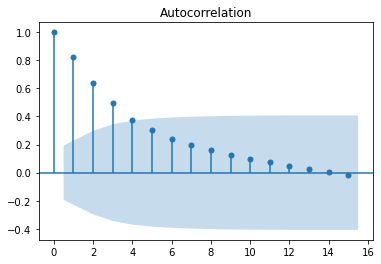

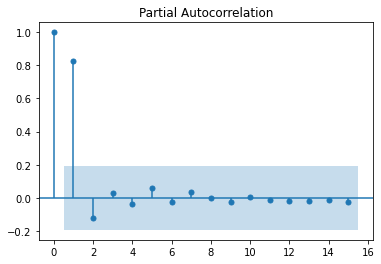

In [13]:
df = data_withSentiment_US_unemployment['UNRATE']
stationarityTest_US_unemployment = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_unemployment[1])
acf = plot_acf(df, lags=15)
pacf = plot_pacf(df, lags=15)

P-value:  0.5984475172171898


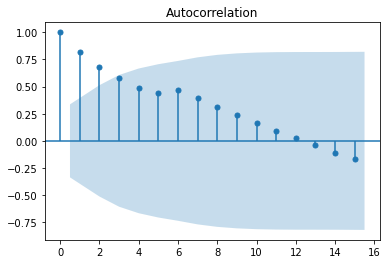

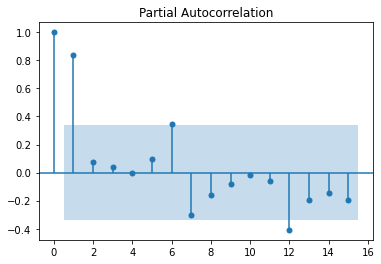

In [14]:
df = data_withSentiment_US_gdp['GDPC1']
stationarityTest_US_gdp = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_gdp[1])
acf = plot_acf(df, lags=15)
pacf = plot_pacf(df, lags=15)

P-value:  0.9984327109949332


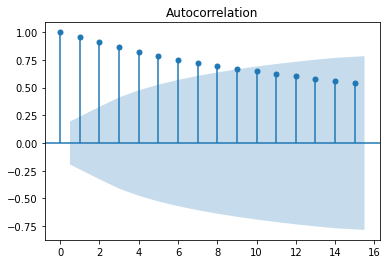

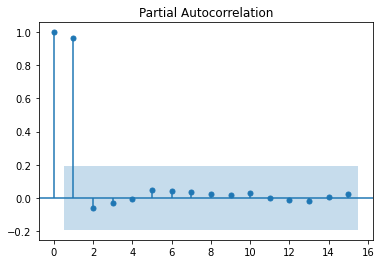

In [15]:
df = data_withSentiment_US_inflation['CPIAUCNS']
stationarityTest_US_inflation = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_inflation[1])
acf = plot_acf(df, lags=15)
pacf = plot_pacf(df, lags=15)

### Baseline Model

In [16]:
import statsmodels.api as sm

In [17]:
X = sm.add_constant(data_withSentiment_US_unemployment['lag_UNRATE'])
Y = data_withSentiment_US_unemployment['UNRATE']
ar_model_US_unemployment = sm.OLS(Y,X).fit()
print(ar_model_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     218.7
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           6.49e-27
Time:                        15:34:14   Log-Likelihood:                -149.70
No. Observations:                 102   AIC:                             303.4
Df Residuals:                     100   BIC:                             308.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9325      0.321      2.904      0.0

In [18]:
X = sm.add_constant(data_withSentiment_US_gdp['lag_GDPC1'])
Y = data_withSentiment_US_gdp['GDPC1']
ar_model_US_gdp = sm.OLS(Y,X).fit()
print(ar_model_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     145.0
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           1.99e-13
Time:                        15:34:14   Log-Likelihood:                -249.54
No. Observations:                  34   AIC:                             503.1
Df Residuals:                      32   BIC:                             506.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1797.2265   1347.180      1.334      0.1

In [19]:
X = sm.add_constant(data_withSentiment_US_inflation['lag_CPIAUCNS'])
Y = data_withSentiment_US_inflation['CPIAUCNS']
ar_model_US_inflation = sm.OLS(Y,X).fit()
print(ar_model_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.225e+04
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          2.73e-119
Time:                        15:34:14   Log-Likelihood:                -112.64
No. Observations:                 102   AIC:                             229.3
Df Residuals:                     100   BIC:                             234.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.7618      1.691     -2.817   

### Model with Sentiment Scores (LR Model)

In [20]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'positive_lr','neutral_lr','negative_lr']])
Y = data_withSentiment_US_unemployment['UNRATE']
lr_model_withSentiment1_current_US_unemployment = sm.OLS(Y,X).fit()
print(lr_model_withSentiment1_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     75.65
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           2.07e-25
Time:                        15:34:14   Log-Likelihood:                -147.67
No. Observations:                 102   AIC:                             303.3
Df Residuals:                      98   BIC:                             313.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7069      0.239      2.961      

In [21]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'sentiment_lr_diff']])
Y = data_withSentiment_US_unemployment['UNRATE']
lr_model_withSentiment2_current_US_unemployment = sm.OLS(Y,X).fit()
print(lr_model_withSentiment2_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     110.8
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           5.48e-26
Time:                        15:34:14   Log-Likelihood:                -148.88
No. Observations:                 102   AIC:                             303.8
Df Residuals:                      99   BIC:                             311.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.9230      0.32

In [22]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'sentiment_lr_ratio']])
Y = data_withSentiment_US_unemployment['UNRATE']
lr_model_withSentiment3_current_US_unemployment = sm.OLS(Y,X).fit()
print(lr_model_withSentiment3_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     109.5
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           8.24e-26
Time:                        15:34:14   Log-Likelihood:                -149.30
No. Observations:                 102   AIC:                             304.6
Df Residuals:                      99   BIC:                             312.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.3659      0

In [23]:
X = sm.add_constant(data_withSentiment_US_gdp[['lag_GDPC1', 'positive_lr','neutral_lr','negative_lr']])
Y = data_withSentiment_US_gdp['GDPC1']
lr_model_withSentiment1_current_US_gdp = sm.OLS(Y,X).fit()
print(lr_model_withSentiment1_current_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     52.09
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           5.25e-12
Time:                        15:34:14   Log-Likelihood:                -247.58
No. Observations:                  34   AIC:                             503.2
Df Residuals:                      30   BIC:                             509.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1060.9046   1601.685     -0.662      

In [24]:
X = sm.add_constant(data_withSentiment_US_gdp[['lag_GDPC1', 'sentiment_lr_diff']])
Y = data_withSentiment_US_gdp['GDPC1']
lr_model_withSentiment2_current_US_gdp = sm.OLS(Y,X).fit()
print(lr_model_withSentiment2_current_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     80.69
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           5.15e-13
Time:                        15:34:14   Log-Likelihood:                -247.59
No. Observations:                  34   AIC:                             501.2
Df Residuals:                      31   BIC:                             505.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1419.8159   2100.94

In [25]:
X = sm.add_constant(data_withSentiment_US_gdp[['lag_GDPC1', 'sentiment_lr_ratio']])
Y = data_withSentiment_US_gdp['GDPC1']
lr_model_withSentiment3_current_US_gdp = sm.OLS(Y,X).fit()
print(lr_model_withSentiment3_current_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     74.23
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           1.51e-12
Time:                        15:34:14   Log-Likelihood:                -248.77
No. Observations:                  34   AIC:                             503.5
Df Residuals:                      31   BIC:                             508.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1205.4569   2841

In [26]:
X = sm.add_constant(data_withSentiment_US_inflation[['CPIAUCNS', 'positive_lr','neutral_lr','negative_lr']])
Y = data_withSentiment_US_inflation['CPIAUCNS']
lr_model_withSentiment1_current_US_inflation = sm.OLS(Y,X).fit()
print(lr_model_withSentiment1_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.030e+28
Date:                Thu, 04 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:34:14   Log-Likelihood:                 2778.3
No. Observations:                 102   AIC:                            -5549.
Df Residuals:                      98   BIC:                            -5538.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.842e-13   7.49e-13     -0.380      

In [27]:
X = sm.add_constant(data_withSentiment_US_inflation[['CPIAUCNS', 'sentiment_lr_diff']])
Y = data_withSentiment_US_inflation['CPIAUCNS']
lr_model_withSentiment2_current_US_inflation = sm.OLS(Y,X).fit()
print(lr_model_withSentiment2_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.121e+28
Date:                Thu, 04 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:34:14   Log-Likelihood:                 2758.6
No. Observations:                 102   AIC:                            -5511.
Df Residuals:                      99   BIC:                            -5503.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.842e-13   1.18e-1

In [28]:
X = sm.add_constant(data_withSentiment_US_inflation[['CPIAUCNS', 'sentiment_lr_ratio']])
Y = data_withSentiment_US_inflation['CPIAUCNS']
lr_model_withSentiment3_current_US_inflation = sm.OLS(Y,X).fit()
print(lr_model_withSentiment3_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.825e+30
Date:                Thu, 04 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:34:14   Log-Likelihood:                 2966.1
No. Observations:                 102   AIC:                            -5926.
Df Residuals:                      99   BIC:                            -5918.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                       0   1.76

### Model with Sentiment Scores (LSTM Model)

In [29]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'positive_lstm','neutral_lstm','negative_lstm']])
Y = data_withSentiment_US_unemployment['UNRATE']
lstm_model_withSentiment1_current_US_unemployment = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment1_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     77.29
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           9.95e-26
Time:                        15:34:14   Log-Likelihood:                -146.91
No. Observations:                 102   AIC:                             301.8
Df Residuals:                      98   BIC:                             312.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8532      1.954      2.484

In [30]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'sentiment_lstm_diff']])
Y = data_withSentiment_US_unemployment['UNRATE']
lstm_model_withSentiment2_current_US_unemployment = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment2_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     109.1
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           9.19e-26
Time:                        15:34:14   Log-Likelihood:                -149.41
No. Observations:                 102   AIC:                             304.8
Df Residuals:                      99   BIC:                             312.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7531    

In [31]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'sentiment_lstm_ratio']])
Y = data_withSentiment_US_unemployment['UNRATE']
lstm_model_withSentiment3_current_US_unemployment = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment3_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     108.5
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           1.13e-25
Time:                        15:34:14   Log-Likelihood:                -149.63
No. Observations:                 102   AIC:                             305.3
Df Residuals:                      99   BIC:                             313.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0399 

In [32]:
X = sm.add_constant(data_withSentiment_US_gdp[['lag_GDPC1', 'positive_lstm','neutral_lstm','negative_lstm']])
Y = data_withSentiment_US_gdp['GDPC1']
lstm_model_withSentiment1_current_US_gdp = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment1_current_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     47.54
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           1.63e-11
Time:                        15:34:14   Log-Likelihood:                -248.88
No. Observations:                  34   AIC:                             505.8
Df Residuals:                      30   BIC:                             511.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           900.8138   2030.883      0.444

In [33]:
X = sm.add_constant(data_withSentiment_US_gdp[['lag_GDPC1', 'sentiment_lstm_diff']])
Y = data_withSentiment_US_gdp['GDPC1']
lstm_model_withSentiment2_current_US_gdp = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment2_current_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     70.88
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           2.73e-12
Time:                        15:34:14   Log-Likelihood:                -249.42
No. Observations:                  34   AIC:                             504.8
Df Residuals:                      31   BIC:                             509.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2658.9089   2

In [34]:
X = sm.add_constant(data_withSentiment_US_gdp[['lag_GDPC1', 'sentiment_lstm_ratio']])
Y = data_withSentiment_US_gdp['GDPC1']
lstm_model_withSentiment3_current_US_gdp = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment3_current_US_gdp.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     75.44
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           1.23e-12
Time:                        15:34:14   Log-Likelihood:                -248.55
No. Observations:                  34   AIC:                             503.1
Df Residuals:                      31   BIC:                             507.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3788.7425 

In [35]:
X = sm.add_constant(data_withSentiment_US_inflation[['lag_CPIAUCNS', 'positive_lstm','neutral_lstm','negative_lstm']])
Y = data_withSentiment_US_inflation['CPIAUCNS']
lstm_model_withSentiment1_current_US_inflation = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment1_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     7389.
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          2.73e-115
Time:                        15:34:14   Log-Likelihood:                -111.81
No. Observations:                 102   AIC:                             231.6
Df Residuals:                      98   BIC:                             242.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.2482      2.297     -2.285

In [36]:
X = sm.add_constant(data_withSentiment_US_inflation[['lag_CPIAUCNS', 'sentiment_lstm_diff']])
Y = data_withSentiment_US_inflation['CPIAUCNS']
lstm_model_withSentiment2_current_US_inflation = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment2_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.102e+04
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          4.89e-117
Time:                        15:34:14   Log-Likelihood:                -112.59
No. Observations:                 102   AIC:                             231.2
Df Residuals:                      99   BIC:                             239.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.3471    

In [37]:
X = sm.add_constant(data_withSentiment_US_inflation[['lag_CPIAUCNS', 'sentiment_lstm_ratio']])
Y = data_withSentiment_US_inflation['CPIAUCNS']
lstm_model_withSentiment3_current_US_inflation = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment3_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCNS   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.110e+04
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          3.54e-117
Time:                        15:34:15   Log-Likelihood:                -112.26
No. Observations:                 102   AIC:                             230.5
Df Residuals:                      99   BIC:                             238.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.9617 

## === End of Project ===